# Construcción de la Simulación

Este notebook es para ir construyendo el simulador poco a poco y por partes

In [3]:
import pandas as pd
import numpy as np
import random
from typing import List, Dict, Tuple
from itertools import permutations
from collections import Counter
from scipy.stats import weibull_min
import ast
import heapq
import matplotlib.pyplot as plt
import seaborn as sns


## Cargando Parámetros de la Simulación

In [4]:
#Distribución de la llegada de los pacientes

distribucion_llegada = pd.read_csv("distribucion_llegada.csv")
distribucion_cantidad_estudios = pd.read_csv("distribucion_cantidad_estudios.csv")
probabilidad_estudios = pd.read_csv("promedio_estudios.csv")

media_tiempo_atencion = pd.read_excel("medias_por_estudio_sucursal.xlsx")
media_tiempo_atencion = media_tiempo_atencion[["Sucursal", "EstudioModalidad", "TAPMinutos"]]


cabinas_por_sucursal = {
    "COYOACAN": {
        "PAPANICOLAOU": 1,
        "NUTRICION": 2,
        "LABORATORIO": 13,
        "RAYOS X": 2,
        "TOMOGRAFIA": 1,
        "ULTRASONIDO": 7,
        "MASTOGRAFIA": 3,
        "OPTOMETRIA": 6,
        "RESONANCIA MAGNETICA": 1,
        "ELECTROCARDIOGRAMA": 2,
        "DENSITOMETRIA": 2
    },
    "CULIACAN": {
        "PAPANICOLAOU": 1,
        "NUTRICION": 4,
        "LABORATORIO": 7,
        "RAYOS X": 1,
        "TOMOGRAFIA": 1,
        "ULTRASONIDO": 6,
        "MASTOGRAFIA": 1,
        "OPTOMETRIA": 4,
        "RESONANCIA MAGNETICA": 1,
        "ELECTROCARDIOGRAMA": 1,
        "DENSITOMETRIA": 1
    },
    "CULIACAN CAÑADAS": {
        "PAPANICOLAOU": 1,
        "NUTRICION": 1,
        "LABORATORIO": 5,
        "RAYOS X": 1,
        "TOMOGRAFIA": 0,
        "ULTRASONIDO": 3,
        "MASTOGRAFIA": 1,
        "OPTOMETRIA": 2,
        "RESONANCIA MAGNETICA": 0,
        "ELECTROCARDIOGRAMA": 1,
        "DENSITOMETRIA": 1
    },
    "CULIACAN COLEGIO MILITAR": {
        "PAPANICOLAOU": 1,
        "NUTRICION": 0,
        "LABORATORIO": 4,
        "RAYOS X": 1,
        "TOMOGRAFIA": 1,
        "ULTRASONIDO": 3,
        "MASTOGRAFIA": 1,
        "OPTOMETRIA": 2,
        "RESONANCIA MAGNETICA": 1,
        "ELECTROCARDIOGRAMA": 1,
        "DENSITOMETRIA": 1
    },
    "CULIACAN LA CONQUISTA": {
        "PAPANICOLAOU": 1,
        "NUTRICION": 0,
        "LABORATORIO": 2,
        "RAYOS X": 1,
        "TOMOGRAFIA": 0,
        "ULTRASONIDO": 1,
        "MASTOGRAFIA": 0,
        "OPTOMETRIA": 1,
        "RESONANCIA MAGNETICA": 0,
        "ELECTROCARDIOGRAMA": 1,
        "DENSITOMETRIA": 0
    },
    "CULIACAN LAS TORRES": {
        "PAPANICOLAOU": 1,
        "NUTRICION": 2,
        "LABORATORIO": 4,
        "RAYOS X": 1,
        "TOMOGRAFIA": 0,
        "ULTRASONIDO": 2,
        "MASTOGRAFIA": 1,
        "OPTOMETRIA": 2,
        "RESONANCIA MAGNETICA": 0,
        "ELECTROCARDIOGRAMA": 1,
        "DENSITOMETRIA": 1
    },
    "CULIACAN NAKAYAMA": {
        "PAPANICOLAOU": 1,
        "NUTRICION": 0,
        "LABORATORIO": 3,
        "RAYOS X": 0,
        "TOMOGRAFIA": 0,
        "ULTRASONIDO": 1,
        "MASTOGRAFIA": 0,
        "OPTOMETRIA": 1,
        "RESONANCIA MAGNETICA": 0,
        "ELECTROCARDIOGRAMA": 1,
        "DENSITOMETRIA": 0
    },
    "CULIACAN UNIVERSITARIOS": {
        "PAPANICOLAOU": 1,
        "NUTRICION": 2,
        "LABORATORIO": 4,
        "RAYOS X": 1,
        "TOMOGRAFIA": 0,
        "ULTRASONIDO": 2,
        "MASTOGRAFIA": 1,
        "OPTOMETRIA": 2,
        "RESONANCIA MAGNETICA": 0,
        "ELECTROCARDIOGRAMA": 1,
        "DENSITOMETRIA": 1
    }
}


# Calcular el total de pacientes por sucursal
total_pacientes_por_sucursal = distribucion_cantidad_estudios.groupby("Sucursal")["NumPacientes"].transform('sum')

# Calcular la probabilidad para cada fila
distribucion_cantidad_estudios["Probabilidad"] = distribucion_cantidad_estudios["NumPacientes"] / total_pacientes_por_sucursal

In [5]:
probabilidad_estudios[probabilidad_estudios["Sucursal"] == "COYOACAN"]

,Sucursal,EstudioModalidad,Probabilidad
56,COYOACAN,LABORATORIO,0.366373
57,COYOACAN,RAYOS X,0.132320
58,COYOACAN,ULTRASONIDO,0.131180
59,COYOACAN,OPTOMETRIA,0.112957
60,COYOACAN,DENSITOMETRIA,0.066428
61,COYOACAN,ELECTROCARDIOGRAMA,0.061017
62,COYOACAN,MASTOGRAFIA,0.031705
63,COYOACAN,PAPANICOLAOU,0.028284
64,COYOACAN,NUTRICION,0.028125
65,COYOACAN,RESONANCIA MAGNETICA,0.021263


## Construyendo dataset para la simulación

In [28]:
#### Utilidades

def filtrar_por_sucursal(df: pd.DataFrame, sucursal: str) -> pd.DataFrame:
    """Devuelve solo las filas de la sucursal y resetea el índice."""
    return df[df["Sucursal"] == sucursal].reset_index(drop=True)


def ajustar_parametros_weibull(tabla_llegadas: pd.DataFrame):
    """
    Ajusta una distribución Weibull a los datos de llegadas por intervalo.
    Devuelve los parámetros (forma, loc, escala).
    """
    datos = tabla_llegadas["Cantidad"].values
    # fit devuelve: (forma, loc, escala)
    params = weibull_min.fit(datos, floc=0)  # fijamos loc=0 para evitar desplazamiento
    return params


def generar_llegadas(tabla_llegadas: pd.DataFrame) -> List[float]:
    """
    Genera tiempos de llegada simulados usando parámetros ajustados de una distribución Weibull.
    """
    from scipy.stats import weibull_min

    # Ajustar parámetros automáticamente
    forma, loc, escala = ajustar_parametros_weibull(tabla_llegadas)

    tiempos = []
    for _, fila in tabla_llegadas.iterrows():
        base = pd.to_timedelta(fila["Hora"]).total_seconds() / 60

        # Sorteo variable usando Weibull
        cantidad = int(weibull_min.rvs(c=forma, loc=loc, scale=escala))
        
        for _ in range(cantidad):
            tiempos.append(base + random.uniform(0, 10))

    return sorted(tiempos)

def sortear_k(tabla_k: pd.DataFrame) -> int:
    """
    De la tabla:
        k, Probabilidad
    devuelve un entero según esa distribución.
    """
    valores = tabla_k["CantidadEstudios"].values
    probs   = tabla_k["Probabilidad"].values
    return int(np.random.choice(valores, p=probs))


def sortear_estudios(tabla_prob: pd.DataFrame, k: int) -> List[str]:
    """
    Tabla:
        EstudioModalidad, Probabilidad
    Sortea k estudios distintos (sin reemplazo).
    """
    est   = tabla_prob["EstudioModalidad"].values
    p     = tabla_prob["Probabilidad"].values
    p     = p / p.sum()                   
    k     = min(k, len(est))              
    elegidos = np.random.choice(est, size=k, replace=False, p=p)
    return list(elegidos)

def generar_pacientes(sucursal: str, fecha: str = "2025-07-01") -> pd.DataFrame:
    # --- A. filtrar ---
    llegadas_suc = filtrar_por_sucursal(distribucion_llegada, sucursal)
    dist_k_suc   = filtrar_por_sucursal(distribucion_cantidad_estudios, sucursal)
    prob_est_suc = filtrar_por_sucursal(probabilidad_estudios, sucursal)

    # --- B. llegadas ---
    tiempos = generar_llegadas(llegadas_suc)

    # --- C. pacientes ---
    pacientes = []
    for pid, t in enumerate(tiempos):
        k = sortear_k(dist_k_suc)
        estudios = sortear_estudios(prob_est_suc, k)
        pacientes.append({
            "PacienteID": pid,
            "LlegadaMin": t,
            "Sucursal":   sucursal,
            "CantidadEstudios": k,
            "Estudios":   estudios,
            "Fecha":      fecha
        })

    return pd.DataFrame(pacientes)

In [ ]:
suc = "CULIACAN"
df_pac = generar_pacientes(suc)

## Algoritmos con Datos Simulados

In [19]:
# ---------------------------------------------------------------------------
# PLANIFICADOR DE RUTAS ÓPTIMAS (EXHAUSTIVO ≤ 5  |  GA ≥ 6)
# ---------------------------------------------------------------------------
# Requiere:
#   • pandas  • numpy  • random  • ast  • itertools
#
# Entradas:
#   1) pacientes_df  -> DataFrame con pacientes de UNA sucursal
#        ├─ PacienteID
#        ├─ LlegadaMin        (minutos desde 00:00)
#        ├─ Sucursal          (misma para todo el DF)
#        ├─ Estudios          (lista o cadena “['LAB', 'RX']”)
#        └─ Fecha
#   2) cabinas_por_sucursal -> {sucursal: {estudio: nº cabinas}}
#   3) tap_df               -> TAP medios por estudio y sucursal
#
# Salida:
#   • DataFrame “agenda” una fila por estudio con:
#        PacienteID, Estudio, Llegada, Inicio, Fin,
#        Tiempo de espera, Tiempo de atencion, Ruta, Fecha, Sucursal
# ---------------------------------------------------------------------------

import pandas as pd
import numpy as np
import random
import ast
import heapq
from collections import Counter
from itertools import permutations
from typing import List, Tuple, Dict

# ╭──────────────────────────────────────────────────────────╮
# │        PARÁMETROS DE VARIABILIDAD / “RUIDO”              │
# ╰──────────────────────────────────────────────────────────╯
SIGMA_ARR    = 2.0   # min – desviación estándar en la hora de llegada
CV_TAP       = 0.30  # sin unidad – coef. de variación del TAP. EL minimo es la media, el maximo es la media + 30% de la media
SIGMA_WALK   = 0.5   # min – desviación estándar en desplazamiento
BASE_TRANSIT = 1.5   # min – tiempo medio de caminar entre áreas
MU_PREP      = 1.0   # min – tiempo medio de preparación previa al siguiente cliente
SIGMA_PREP   = 0.5   # min – desviación estándar de preparación
PROB_REPETIR = 0.03  # 3% de estudios se repiten
SEED         = None   # reproducibilidad

rng = np.random.default_rng(SEED)

# ╭──────────────────────────────────────────────────────────╮
# │      FUNCIONES DE COSTE / RUTA / GA                      │
# ╰──────────────────────────────────────────────────────────╯

def simula_ruta(ruta: Tuple[str, ...], arrival: float,
                tap: Dict[str, float], cabinas_snapshot: Dict[str, List[float]]) -> float:
    cabinas = {e: t.copy() for e, t in cabinas_snapshot.items()}
    t = arrival
    for est_tag in ruta:
        base = est_tag.split('#')[0]
        dur  = tap[est_tag]
        idx  = min(range(len(cabinas[base])), key=cabinas[base].__getitem__)
        start = max(t, cabinas[base][idx])
        end   = start + dur
        cabinas[base][idx] = end
        t = end
    return t - arrival


def mut_swap(ind):
    if len(ind) < 2:
        return ind
    i, j = random.sample(range(len(ind)), 2)
    ind = list(ind)
    ind[i], ind[j] = ind[j], ind[i]
    return tuple(ind)


def ox(p1, p2):
    k = len(p1)
    a, b = sorted(random.sample(range(k), 2))
    child1 = [None] * k
    child1[a:b] = p1[a:b]
    need, have = Counter(p1), Counter(child1[a:b])
    pos = b
    for g in p2:
        if have[g] >= need[g]:
            continue
        while child1[pos % k] is not None:
            pos += 1
        child1[pos % k] = g
        have[g] += 1
        pos += 1
    child2 = [None] * k
    child2[a:b] = p2[a:b]
    need, have = Counter(p2), Counter(child2[a:b])
    pos = b
    for g in p1:
        if have[g] >= need[g]:
            continue
        while child2[pos % k] is not None:
            pos += 1
        child2[pos % k] = g
        have[g] += 1
        pos += 1
    return tuple(child1), tuple(child2)


def mejor_ruta_exhaustiva(estudios: List[str], arrival, tap, cabinas_snapshot):
    best, best_t = None, float('inf')
    for perm in permutations(estudios):
        tat = simula_ruta(perm, arrival, tap, cabinas_snapshot)
        if tat < best_t:
            best, best_t = perm, tat
    return best, best_t


def ga_ruta(estudios: List[str], arrival, tap, cabinas_snapshot,
            N=40, G=120, pc=0.9, pm=None):
    if pm is None:
        pm = 1 / len(estudios)

    def fitness(r): return 1.0 / simula_ruta(r, arrival, tap, cabinas_snapshot)
    def torneo(pop): return max(random.sample(pop, 3), key=fitness)

    pobl = [tuple(random.sample(estudios, len(estudios))) for _ in range(N)]
    best = min(pobl, key=fitness)
    for _ in range(G):
        nueva = [best]
        while len(nueva) < N:
            p1, p2 = torneo(pobl), torneo(pobl)
            h1, h2 = ox(p1, p2) if random.random() < pc else (p1, p2)
            if random.random() < pm: h1 = mut_swap(h1)
            if random.random() < pm: h2 = mut_swap(h2)
            nueva.extend((h1, h2))
        pobl = nueva[:N]
        cand = min(pobl, key=fitness)
        if fitness(cand) < fitness(best):
            best = cand
    return best, simula_ruta(best, arrival, tap, cabinas_snapshot)


# ╭──────────────────────────────────────────────────────────╮
# │             PLANIFICADOR CON RUIDO                       │
# ╰──────────────────────────────────────────────────────────╯

def planificar_dia(pacientes_df: pd.DataFrame,
                   cabinas_por_sucursal: Dict[str, Dict[str, int]],
                   tap_df: pd.DataFrame) -> pd.DataFrame:

    df = pacientes_df.sort_values('LlegadaMin').reset_index(drop=True)
    df['Estudios'] = df['Estudios'].apply(
        lambda x: ast.literal_eval(x) if not isinstance(x, list) else x
    )

    sucursal = df['Sucursal'].iloc[0]
    capacidad = cabinas_por_sucursal[sucursal]
    cabinas = {e: [0.0] * capacidad[e] for e in capacidad}

    tap_base = (tap_df.query("Sucursal == @sucursal")
                      .set_index('EstudioModalidad')['TAPMinutos']
                      .to_dict())

    agenda, rutas = [], {}

    for _, pac in df.iterrows():
        k = len(pac['Estudios'])
        if k <= 5:
            ruta, _ = mejor_ruta_exhaustiva(pac['Estudios'],
                                            pac['LlegadaMin'], tap_base, cabinas)
        else:
            ruta, _ = ga_ruta(pac['Estudios'],
                              pac['LlegadaMin'], tap_base, cabinas)
        rutas[pac['PacienteID']] = ruta

    event_q = []
    for _, pac in df.iterrows():
        arr = max(0.0, pac['LlegadaMin'] + rng.normal(0, SIGMA_ARR))
        heapq.heappush(event_q, (arr, 'arrival',
                                 pac['PacienteID'], 0, pac['Fecha']))

    llegada_estudio = {}
    dur_estudio = {}

    def tap_real(est):
        base = tap_base[est]
        sample = rng.normal(base, base * CV_TAP)
        return max(base, sample)

    while event_q:
        t, kind, pid, idx, fecha = heapq.heappop(event_q)
        est = rutas[pid][idx]

        if kind == 'arrival':
            q_time = t + max(0, BASE_TRANSIT + rng.normal(0, SIGMA_WALK))
            llegada_estudio[(pid, idx)] = q_time
            heapq.heappush(event_q, (q_time, 'start', pid, idx, fecha))

        elif kind == 'start':
            idx_cab = min(range(len(cabinas[est])), key=cabinas[est].__getitem__)
            dur = tap_real(est)
            prep_time = max(0, rng.normal(MU_PREP, SIGMA_PREP))
            start = max(t + prep_time, cabinas[est][idx_cab])
            fin = start + dur
            cabinas[est][idx_cab] = fin
            dur_estudio[(pid, idx)] = dur
            llegada_estudio[(pid, ('inicio', idx))] = start
            heapq.heappush(event_q, (fin, 'finish', pid, idx, fecha))

        else:  # finish
            q_time = llegada_estudio.pop((pid, idx))
            start = llegada_estudio.pop((pid, ('inicio', idx)))
            dur = dur_estudio.pop((pid, idx))

            agenda.append({
                'PacienteID': pid,
                'Sucursal': sucursal,
                'Estudio': est,
                'Llegada': q_time,
                'Inicio': start,
                'Fin': t,
                'Tiempo de espera': start - q_time,
                'Tiempo de atencion': dur,
                'Ruta': rutas[pid],
                'Fecha': fecha
            })

            # Verifica si hay que repetir el estudio
            if rng.random() < PROB_REPETIR:
                q_reintento = t + max(0, BASE_TRANSIT + rng.normal(0, SIGMA_WALK))
                llegada_estudio[(pid, idx)] = q_reintento
                heapq.heappush(event_q, (q_reintento, 'start', pid, idx, fecha))
                continue

            # Si no hay repetición, avanza al siguiente
            if idx + 1 < len(rutas[pid]):
                q_next = t + max(0, BASE_TRANSIT + rng.normal(0, SIGMA_WALK))
                llegada_estudio[(pid, idx + 1)] = q_next
                heapq.heappush(event_q, (q_next, 'start', pid, idx + 1, fecha))

    return pd.DataFrame(agenda)



## Simulando 1 mes completo

In [87]:
# Generar planificación para un mes completo
suc = "CULIACAN"
tap_df = media_tiempo_atencion[media_tiempo_atencion["Sucursal"] == suc]

# Lista para almacenar todas las agendas
agendas_mes = []

# Generar y planificar para cada día del mes
for dia in range(1, 20):
    # Generar fecha para el día actual
    fecha = pd.Timestamp('2025-03-01') + pd.Timedelta(days=dia-1)
    
    # Generar pacientes para el día
    df_pac = generar_pacientes(suc)
    df_pac['Fecha'] = fecha.date()  # Asignar la fecha a los pacientes
    
    # Planificar el día
    agenda_dia = planificar_dia(df_pac, cabinas_por_sucursal, tap_df)
    
    # Agregar a la lista de agendas
    agendas_mes.append(agenda_dia)

# Concatenar todas las agendas en un solo DataFrame
agenda_mes_completo = pd.concat(agendas_mes, ignore_index=True)


In [88]:
agenda_mes_completo

,PacienteID,Sucursal,Estudio,Llegada,Inicio,Fin,Tiempo de espera,Tiempo de atencion,Ruta,Fecha
0,0,CULIACAN,OPTOMETRIA,350.940583,352.333922,363.330267,1.393339,10.996346,"(OPTOMETRIA,)",2025-03-01
1,1,CULIACAN,ULTRASONIDO,354.355082,355.517157,366.224702,1.162075,10.707545,"(ULTRASONIDO, DENSITOMETRIA, LABORATORIO)",2025-03-01
2,6,CULIACAN,LABORATORIO,363.938285,364.517767,368.156202,0.579483,3.638434,"(LABORATORIO,)",2025-03-01
3,2,CULIACAN,OPTOMETRIA,356.822179,358.175770,369.023486,1.353590,10.847716,"(OPTOMETRIA, ULTRASONIDO, RESONANCIA MAGNETICA)",2025-03-01
4,5,CULIACAN,RAYOS X,364.047698,364.681759,369.610119,0.634061,4.928360,"(RAYOS X,)",2025-03-01
...,...,...,...,...,...,...,...,...,...,...
11674,369,CULIACAN,LABORATORIO,1288.273375,1288.960782,1292.765362,0.687407,3.804580,"(TOMOGRAFIA, RAYOS X, LABORATORIO)",2025-03-19
11675,371,CULIACAN,LABORATORIO,1425.517608,1426.327511,1430.650799,0.809903,4.323288,"(LABORATORIO,)",2025-03-19
11676,372,CULIACAN,OPTOMETRIA,1429.121016,1429.654097,1440.501813,0.533081,10.847716,"(OPTOMETRIA, ULTRASONIDO, LABORATORIO)",2025-03-19
11677,372,CULIACAN,ULTRASONIDO,1442.057517,1443.001467,1454.192898,0.943950,11.191431,"(OPTOMETRIA, ULTRASONIDO, LABORATORIO)",2025-03-19


### Optimización vs No Optimización

In [89]:
def graficar_distribucion(df, columna, remover_outliers=True, max_valor=None, bins=35, titulo=None):
    """
    Grafica la distribución de una columna numérica con opciones de filtrado.
    
    Parámetros:
    -----------
    df : DataFrame
        DataFrame a analizar
    columna : str
        Nombre de la columna a graficar
    remover_outliers : bool, default True
        Si es True, remueve los outliers antes de la visualización
    max_valor : float, default None
        Valor máximo a considerar en el análisis
    bins : int, default 50
        Número de barras para el histograma
    titulo : str, default None
        Título personalizado para la gráfica
    """
    
    # Crear una copia del DataFrame para no modificar el original
    df_analisis = df.copy()
    
    # Aplicar filtro de valor máximo si se especifica
    if max_valor is not None:
        df_analisis = df_analisis[df_analisis[columna] < max_valor]
        print(f"\nDatos filtrados: solo valores menores a {max_valor}")
        print(f"Registros después del filtro: {len(df_analisis)}")
        print(f"Registros removidos: {len(df) - len(df_analisis)}")
    
    if remover_outliers:
        # Calcular los límites para los outliers usando IQR
        Q1 = df_analisis[columna].quantile(0.25)
        Q3 = df_analisis[columna].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filtrar outliers
        df_analisis = df_analisis[(df_analisis[columna] >= lower_bound) & 
                                 (df_analisis[columna] <= upper_bound)]
        
        # Calcular estadísticas de outliers
        n_outliers = len(df) - len(df_analisis)
        print(f"\nNúmero de outliers removidos: {n_outliers}")
        print(f"Porcentaje de datos removidos: {(n_outliers/len(df))*100:.2f}%")
    
    # Configurar el estilo de las gráficas
    plt.figure(figsize=(15, 10))
    
    # Crear una figura con 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Histograma con KDE
    sns.histplot(data=df_analisis, x=columna, kde=True, bins=bins, ax=ax1)
    ax1.set_title(f'Distribución de {columna}' + 
                  (' (sin outliers)' if remover_outliers else '') +
                  (f' (< {max_valor})' if max_valor is not None else ''))
    ax1.set_xlabel(columna)
    ax1.set_ylabel('Frecuencia')
    
    # Boxplot
    sns.boxplot(data=df_analisis, y=columna, ax=ax2)
    ax2.set_title(f'Boxplot de {columna}' + 
                  (' (sin outliers)' if remover_outliers else '') +
                  (f' (< {max_valor})' if max_valor is not None else ''))
    ax2.set_ylabel(columna)
    
    plt.tight_layout()
    plt.show()
    
    # Mostrar estadísticas descriptivas
    print(f"\nEstadísticas descriptivas de {columna}" + 
          (' (sin outliers)' if remover_outliers else '') +
          (f' (< {max_valor})' if max_valor is not None else ''))
    print(df_analisis[columna].describe())
    


In [24]:
df_reales = pd.read_excel("Tiempos Pacientes Limpios.xlsx")


Datos filtrados: solo valores menores a 80
Registros después del filtro: 17039
Registros removidos: 1146


<Figure size 1500x1000 with 0 Axes>

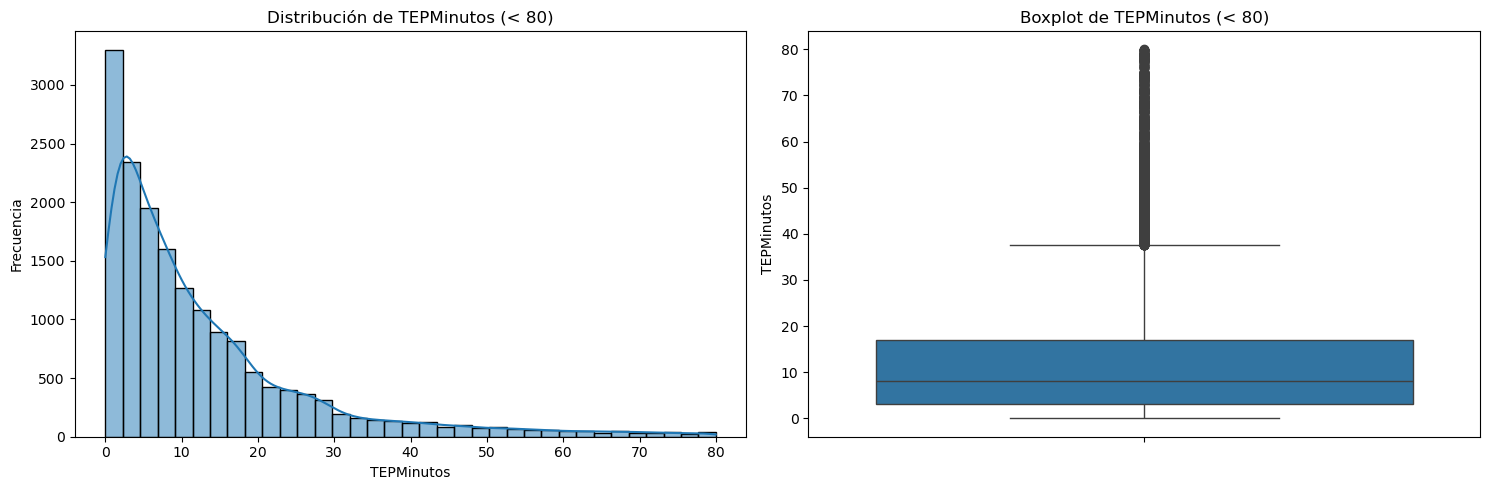


Estadísticas descriptivas de TEPMinutos (< 80)
count    17039.000000
mean        12.848685
std         14.195411
min          0.000000
25%          3.120000
50%          8.080000
75%         16.886692
max         79.996217
Name: TEPMinutos, dtype: float64


In [90]:
graficar_distribucion(df_reales[df_reales["Sucursal"] == "CULIACAN"], 'TEPMinutos', max_valor=80, remover_outliers=False)


Datos filtrados: solo valores menores a 80
Registros después del filtro: 11679
Registros removidos: 0


<Figure size 1500x1000 with 0 Axes>

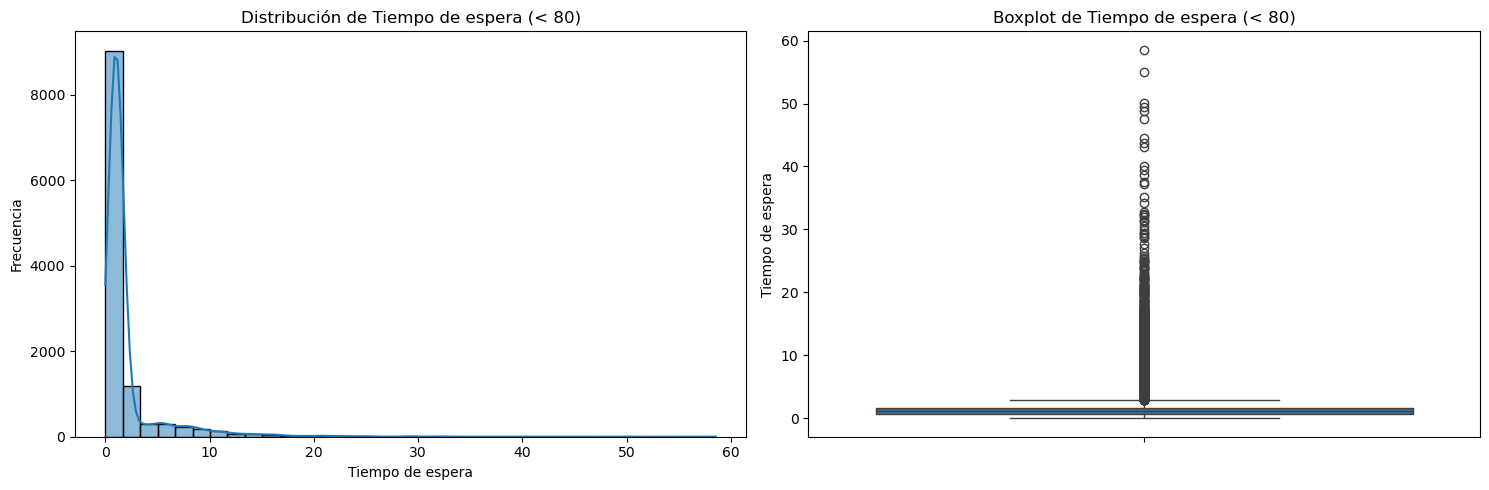


Estadísticas descriptivas de Tiempo de espera (< 80)
count    11679.000000
mean         2.084128
std          3.535733
min          0.000000
25%          0.736923
50%          1.124175
75%          1.590818
max         58.539765
Name: Tiempo de espera, dtype: float64


In [91]:
graficar_distribucion(agenda_mes_completo, 'Tiempo de espera', max_valor=80, remover_outliers=False)

In [ ]:
# Mostrar información del resultado
print(f"Total de registros en el mes: {len(agenda_mes_completo)}")
print("\nDistribución por día:")
print(agenda_mes_completo.groupby('Fecha').size())

# Mostrar estadísticas generales
print("\nEstadísticas de tiempos de espera:")
print(agenda_mes_completo['Tiempo de espera'].describe())